<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (**Interested students might consider adding some additional features from their model, but this is not required for this project**).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [198]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [199]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [200]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [201]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [202]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [203]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + (F(t[i]) - gamma * (T[i] - theta[i])) / C_s
    theta[i+1] = theta[i] + gamma*(T[i] - theta[i]) / C_d

After you are finished, run the cell below to plot the results

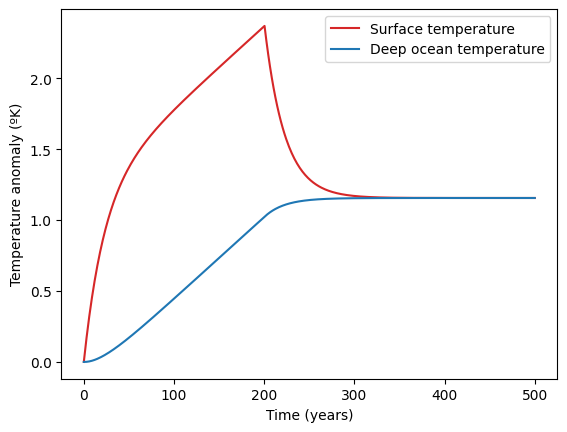

In [204]:
plt.plot(t,T,color='tab:red')
plt.plot(t,theta,color='tab:blue')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain these rates by defining characteristic timescales from the box model equations?

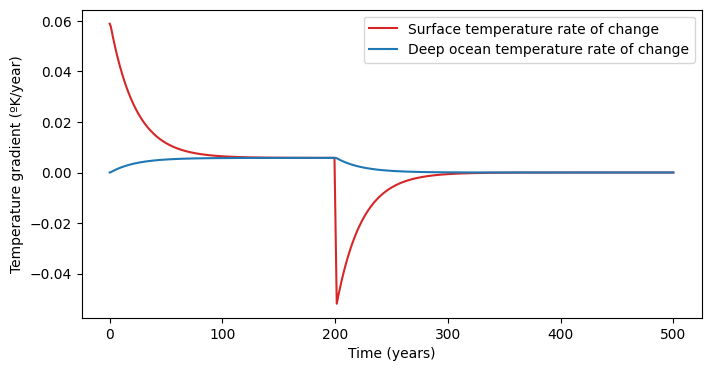

The initial rate of change for the surface temperature is 0.0588ºK/year
The initial rate of change for the deep ocean temperature is 0.0ºK/year


In [205]:
gradient_T = np.gradient(T)
gradient_theta = np.gradient(theta)

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(t, gradient_T, color='tab:red', label='Surface temperature rate of change')
ax.plot(t, gradient_theta, color='tab:blue', label='Deep ocean temperature rate of change')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Temperature gradient (ºK/year)')
ax.legend()
plt.show()

print(f'The initial rate of change for the surface temperature is {round(gradient_T[0], 4)}ºK/year')
print(f'The initial rate of change for the deep ocean temperature is {gradient_theta[0]}ºK/year')

In [206]:
print(2 *gamma/C_d)
print(gradient_theta[100])

0.00858974358974359
0.005712601246749466


In [207]:
tau = C_s/gamma
print(tau)

25.37313432835821


The initial rate of change of the surface ocean temperature begins at $0.0588º K year^-1$, and decreases exponentially to a fixed value. In contrast, the deep ocean temperature increases concave down from an initial rate of zero, approaching the same rate of change as in the surface area.  

###Let's consider some different methods of determining the timescales for $T$ and $\theta$.

####1. $T>>\theta$
Before 200 years, let's say that $T>>\theta$.

\begin{align}
\delta_tT = \frac{1}{C_s}(F(t) - \gamma T) \\
\delta_tT = \frac{1}{C_s}(1 - \gamma T) \\
\int \frac{C_S}{1-\gamma T}dT = \int 1 dt \\
T = \frac{1 - \exp{(-\frac{\gamma}{C_s}t)}}{\gamma} \\
\tau_T = \frac{C_s}{\gamma}
\end{align}

Subbing in the values, $\tau_T = 25.4 \ years$.

Hence the temperature of the surface ocean changes with a characteristic time scale of approximately 25 years.

Now let's approach the timescale for the deep ocean, $\tau_\theta$. Sub in the equation for $T$ above into the differential equation for $\theta$, in the case where $T>>\theta$.

\begin{align}
\frac{\delta \theta}{\delta t} = \frac{\gamma}{C_d} (\frac{1 - exp{(-\frac{\gamma}{C_s}t)}}{\gamma}) \\
\theta = \frac{t+\frac{C_s}{\gamma}\exp{(-t\frac{\gamma}{C_s})}}{C_d} \\
\tau_\theta \simeq \frac{C_s}{\gamma}
\end{align}


This seems rather counter-intuitive based on the results above. The deep ocean seems to respond more slowly than the surface ocean, which is intuitively because $C_d>>C_s$. I am concerned that $C_d$ is not present in the time constant for the deep ocean.

*Note* - I have only analysed the time scale when $F$ is 1, since we are considering the start of the simulation run. The characteristic time scale will be different with a different $F$, particularly in the more realistic scenario where $F$ is a function of $t$.


####2. Keeping the other variable constant

First for the surface ocean:

\begin{align}
\partial_t T = \frac{F(t) - \gamma(T-\theta)}{C_s} \\
\partial_t T = \frac{1 - \gamma(T-\theta)}{C_s} \\
T = \theta + \frac{1-\exp{(-\frac{\gamma t}{C_s})}}{\gamma}
\end{align}

Taking the e-folding time as the characteristic time scale, we once again get:
$$
\tau_T = \frac{C_s}{\gamma}
$$



$$ C_d \partial_t \theta = \gamma (T-\theta) $$


TRY SUBSTITUTION T-THETA?

Let's consider the timescale of equilibration between the deep and surface ocean:

find d(T-theta)

####3. solving for $\Delta T$






### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

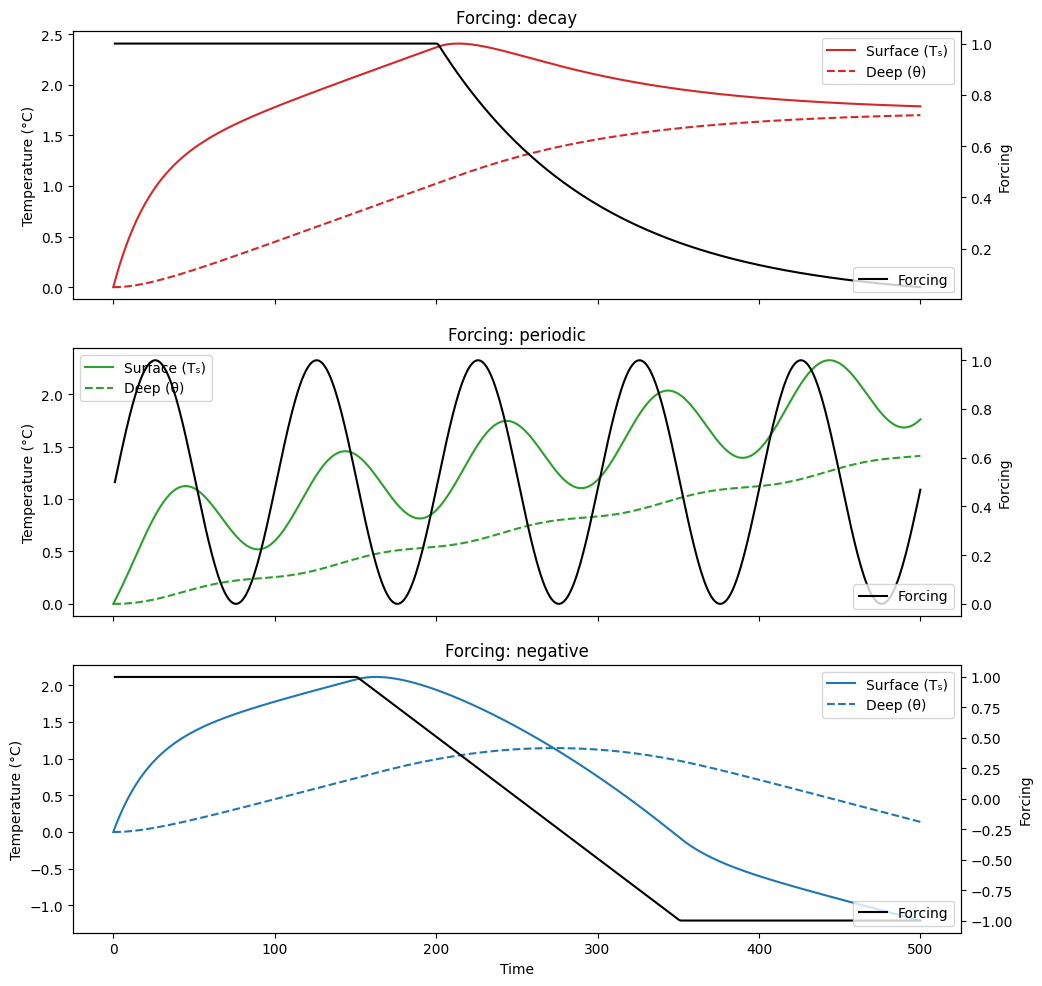

In [208]:
# Add code to make plots here
#do different vals of flux to show same thing

# 1 - F(t) exponentially decays (more realistic)
def F_decay(t):
    tau = 100  # decay time of carbon emissions
    if t <= 200:
        return 1
    else:
        return np.exp(-(t - 200) / tau)

# 2 - F(t) is periodic (changing governments lol)
def F_periodic(t):
    return 0.5 + 0.5* np.sin(2 * np.pi * t / 100)

# 3 - F(t) becomes negative (carbon uptake)
def F_negative(t):
    if t <= 150:
        return 1
    elif t <= 350:
        return 1 - (t - 150) * 0.01
    else:
        return -1

# Store forcing functions and colors
Fs = {
    'decay': F_decay,
    'periodic': F_periodic,
    'negative': F_negative,
}
colors = {
    'decay': 'tab:red',
    'periodic': 'tab:green',
    'negative': 'tab:blue',
}

axes = {}

t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

# Create plots
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fig.tight_layout(pad=2.5)

for i, (scenario, F_func) in enumerate(Fs.items()):
    Ts = np.zeros(Nt)
    thetas = np.zeros(Nt)
    Fs = np.zeros(Nt)
    Ts[0] = 0
    Fs[0] = np.nan


    for n in range(Nt - 1):
        Ts[n + 1] = Ts[n] + dt * (F_func(t[n]) - gamma * (Ts[n] - thetas[n])) / C_s
        thetas[n + 1] = thetas[n] + dt * gamma * (Ts[n] - thetas[n]) / C_d
        Fs[n+1] = F_func(t[n])

    ax[i].plot(t, Ts, color=colors[scenario], label='Surface (Tₛ)')
    ax[i].plot(t, thetas, '--', color=colors[scenario], label='Deep (θ)')
    ax[i].set_ylabel('Temperature (°C)')
    ax[i].set_title(f'Forcing: {scenario}')
    ax[i].legend()


    axes[scenario] = ax[i].twinx()
    axes[scenario].plot(t, Fs, color='black', label='Forcing')
    axes[scenario].set_ylabel('Forcing')
    axes[scenario].legend(loc='lower right')

ax[-1].set_xlabel('Time')
plt.show()






### Scenario 1: forcing decays exponentially
It is unrealistic that the forcing would reduce instantaneously to zero, no matter how dramatic and unrealistic any government's net zero plans are. Hence, I have modelled F as decreasing exponentially to zero following 200 years of an enhanced heat flux into the system, with an e folding time of 100 years. This results in a more gradual redution in surface temperature and increase in deep ocean temperature compared to a step function fotr F. This makes sense intuitively.

### Scenario 2: forcing is periodic
We live in a geopoliticial world of extremes that is increasingly polarising. Therefore, I have modelled a periodic forcing on the ocean to represent changing governmental regimes reaching net zero and then returning to a reliance on fossil fuels. Note that whilst the 100 year wavelength periodicity is very evident in the surface ocean, this is extensively damped in the deep ocean where the cycle is hard to see. Instead, the deep ocean reflects mainly the time-smoothed increase in residual heat within the system. This reflects the importance of sustained emissions reduction, and ideally a negative heat flux to counteract the residual net heat in the system. This brings us on to the next scenario...

### Scenario 3: forcing becomes negative
There is increasing focus (often polarising) on geoengineering solutions to combat anthropogenic climate change. For example, the Centre for Climate Repair at Cambridge is actively researching the potential of cloud brightening to increase global (or perhaps local) albedo. The idea is to spray very fine seawater aerosols into the atmosphere, which act as cloud condensation nuclei and consequently increase cloud cover. Though the outcome of this is hotly debated, it is thought by some that an increase in the volume and longevity of clouds which reflect more incoming solar radiation. Hence I have modelled a scenario where, following 150 years of enhanced incoming heat flux, cloud brightening is deployed resulting in a negative net heat flux after 100 years. The surface ocean responds relatively quickly, with a response time of around 25 years as discussed above. In contrast, the response of the deep ocean is once again damped.



INSERT DISCUSSION HERE

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [209]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [210]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [211]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [212]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [213]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [214]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.08 seconds


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

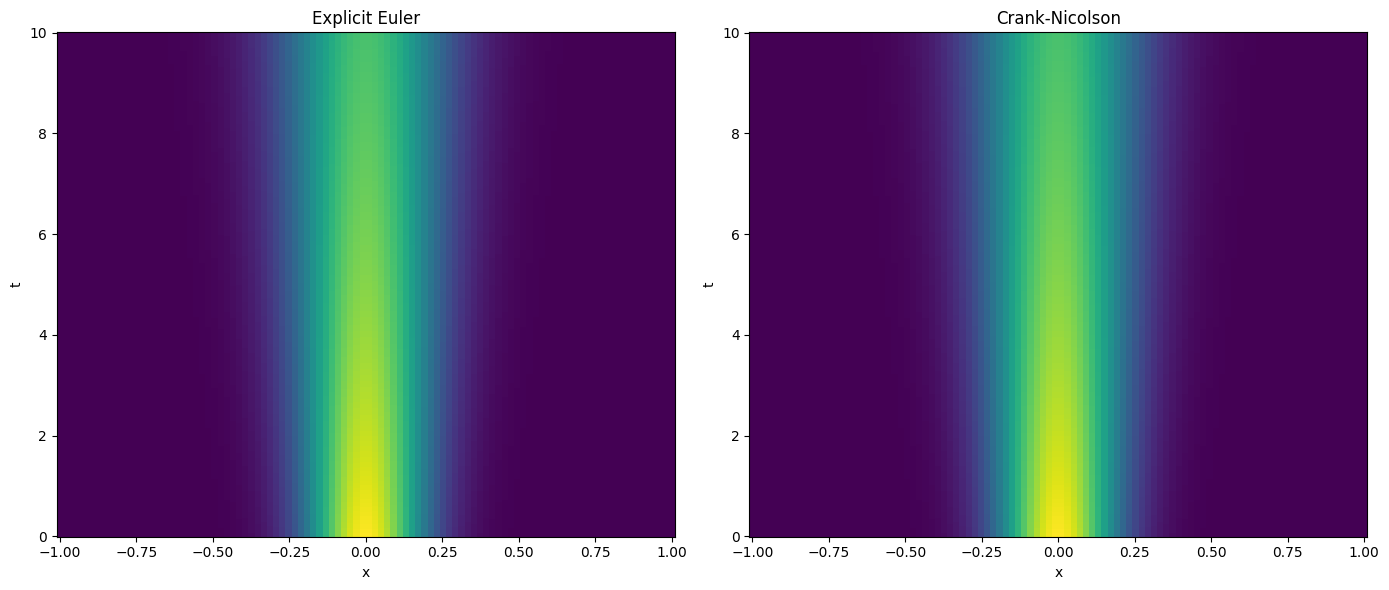

In [215]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

Explicit Euler method took 0.67 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.05 seconds
Explicit Euler method took 0.04 seconds
Crank-Nicolson method took 0.06 seconds


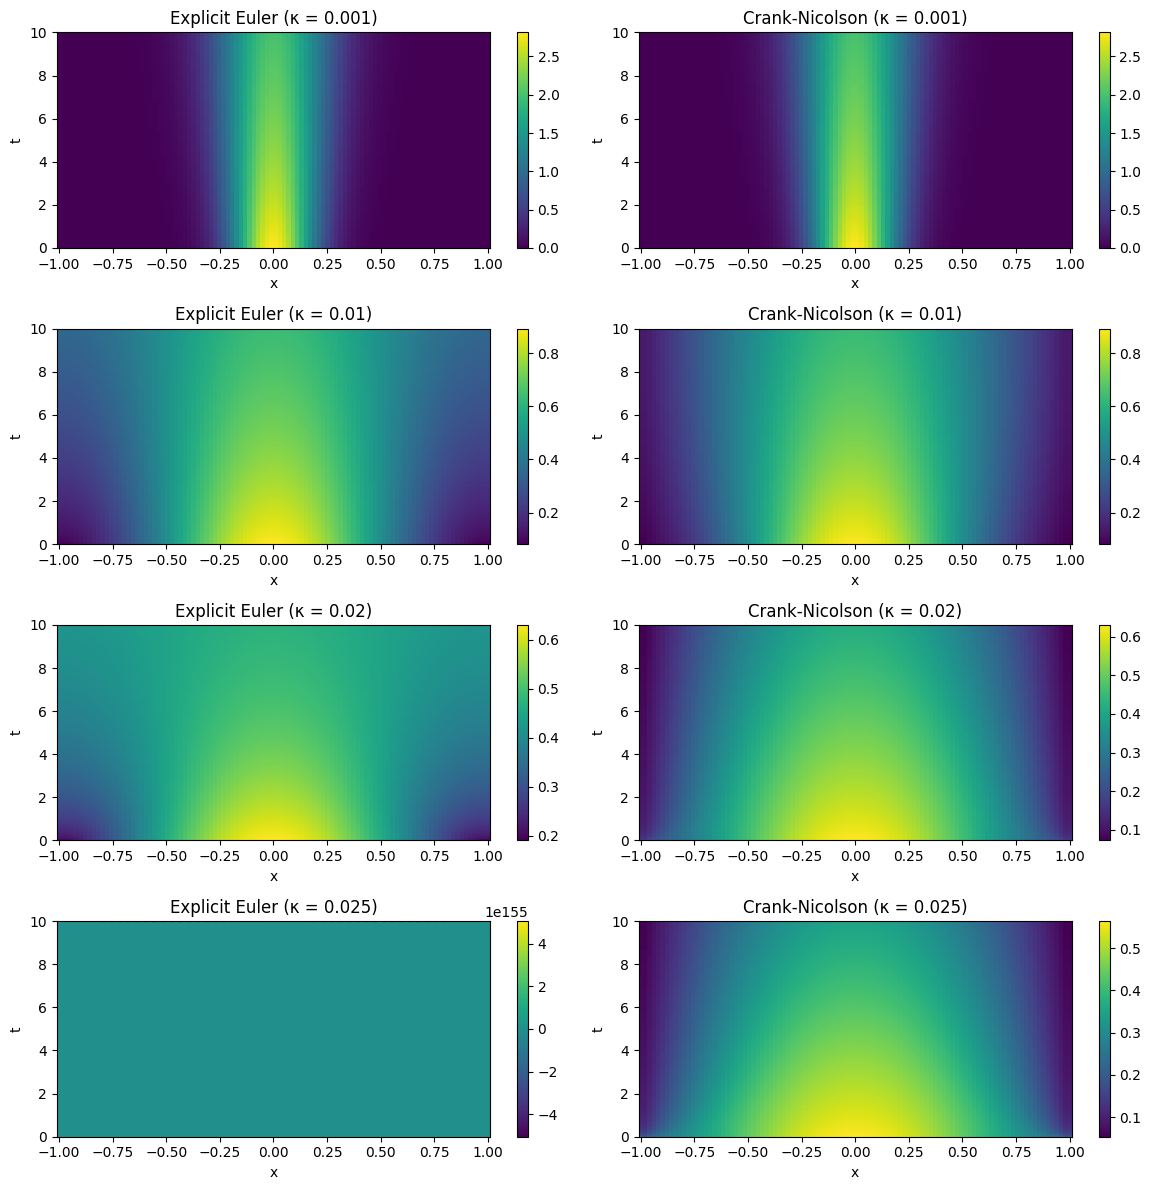

In [216]:
kappa_values = [0.001, 0.01, 0.02, 0.025]  # diffusivity values

fig, axes = plt.subplots(len(kappa_values), 2, figsize=(12, 3 * len(kappa_values)))

for i, kappa in enumerate(kappa_values):
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)

    # Explicit Euler
    ax1 = axes[i, 0]
    pcm1 = ax1.pcolormesh(x, t, c_EE.T, shading='auto')
    fig.colorbar(pcm1, ax=ax1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_title(f'Explicit Euler (κ = {kappa})')

    # Crank-Nicolson
    ax2 = axes[i, 1]
    pcm2 = ax2.pcolormesh(x, t, c_CN.T, shading='auto')
    fig.colorbar(pcm2, ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('t')
    ax2.set_title(f'Crank-Nicolson (κ = {kappa})')

plt.tight_layout()
plt.show()


Evidently it seems that in this case the explicit Euler becomes unstable much quicker. Above around $ \kappa \simeq 0.02$ the results are very unstable, and by $\kappa \simeq 0.03$, the system reaches infinite values and crashes the simulation. Even prior to $ \kappa \simeq 0.02$, the solution with the Explicit Euler method seems much more diffusive, evident in the $ \kappa \simeq 0.01$ simulation above.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler method took 0.06 seconds
Crank-Nicolson method took 0.05 seconds


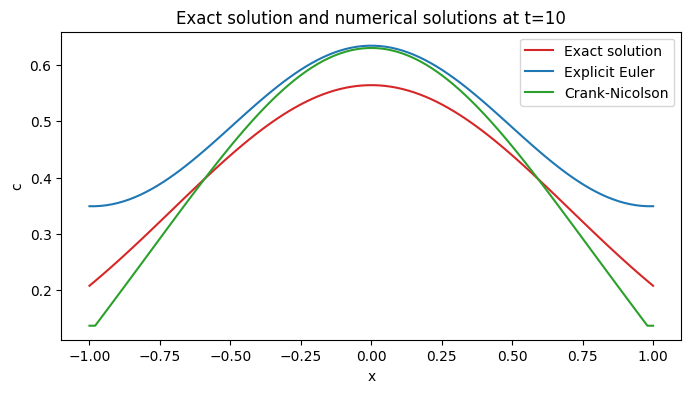

In [217]:
#exact solution at t=10
exact_x = np.linspace(-1,1, Nx)
exact_10 = (1/(4*np.pi*kappa*10))**0.5 * np.exp(-exact_x**2/(4*kappa*10))
kappa = 0.01

# Run the simulations, and get the values at t=10
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(exact_x, exact_10, color='tab:red', label='Exact solution')
ax.plot(x, c_EE[:, -1], color='tab:blue', label='Explicit Euler')
ax.plot(x, c_CN[:, -1], color='tab:green', label='Crank-Nicolson')

ax.set_xlabel('x')
ax.set_ylabel('c')
ax.legend()
ax.set_title('Exact solution and numerical solutions at t=10')
plt.show()


The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.05 seconds


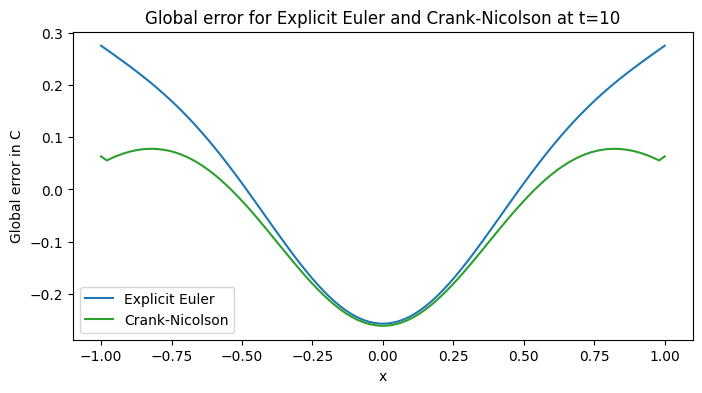

NRMSE for Explicit Euler: 127.77812415649879
NRMSE for Crank-Nicolson: 12.139429073314776


In [218]:
#plot global error for each

#exact solution at t=10
exact_x = np.linspace(-1,1, Nx)
exact_10 = (1/(4*np.pi*kappa*10))**0.5 * np.exp(-exact_x**2/(4*kappa*10))


# Run the simulations, and get the values at t=10
kappa = 0.01
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

ge_EE = c_EE[:, -1] - exact_10
ge_CN = c_CN[:, -1] - exact_10

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(x, ge_EE, color='tab:blue', label='Explicit Euler')
ax.plot(x, ge_CN, color='tab:green', label='Crank-Nicolson')
ax.set_xlabel('x')
ax.set_ylabel('Global error in C')
ax.legend()
ax.set_title('Global error for Explicit Euler and Crank-Nicolson at t=10')

plt.show()

#we can also calculate the NRMSE

NRMSE_EE = np.sum((c_EE[:,-1] - exact_10)**2/exact_10**2)
NRMSE_CN = np.sum((c_CN[:,-1] - exact_10)**2/exact_10**2)

print(f'NRMSE for Explicit Euler: {NRMSE_EE}')
print(f'NRMSE for Crank-Nicolson: {NRMSE_CN}')



Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.



For an ODE $$\frac{dy}{dt} = f(t, y),$$ the Explicit Euler method  

$$
y_{n+1} = y_n + \Delta t\, f(t_n, y_n)
$$

can be compared with the Taylor expansion of the exact solution  

$$
y(t_{n+1}) = y(t_n) + \Delta t\, f(t_n, y_n) + \frac{(\Delta t)^2}{2} y''(t_n) + O(\Delta t^3),
$$

showing that the local truncation error is $ O(\Delta t^2) $.

When considering the global error, there are \(N = T / \Delta t\) steps up to the final time \(T\).  

The global error accumulates roughly linearly:

$$
\text{Global Error} \sim N \cdot O(\Delta t^2) = \frac{T}{\Delta t} \cdot O(\Delta t^2) = O(\Delta t)
$$

Therefore, Explicit Euler is first-order accurate globally, even though its local error is second-order.  

The **Crank–Nicolson** (trapezoidal) method  

$$
y_{n+1} = y_n + \frac{\Delta t}{2}\,[f(t_n, y_n) + f(t_{n+1}, y_{n+1})]
$$

matches the Taylor expansion up to $ O(\Delta t^3) $, yielding a local error $ O(\Delta t^3) $ and a global error $ O(\Delta t^2) $, by the same justification above.

Thus, Explicit Euler is first-order accurate, while Crank–Nicolson achieves second-order global accuracy.

### Some further exploration of Accuracy

Below, I have plotted the runtime and NRMSE for different values of dt. One can see the linear (and near constant) error of Crank-Nicolson over the range $0.0001$ to $0.02 s$, with a non linear increasing error for the Explicit Euler scheme. However, the latter does not appear to be purely quadratic in form, which is intriguing. At higher dt, the Explicit Euler method becomes massively unstable and collapses, but interestinly returns to stability when dt = 0.1.


In [219]:
#make the functions for EE and CN return runtime


def EE_2(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time


    return c, end_time - start_time

def CN_2(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    return c, end_time - start_time

Done


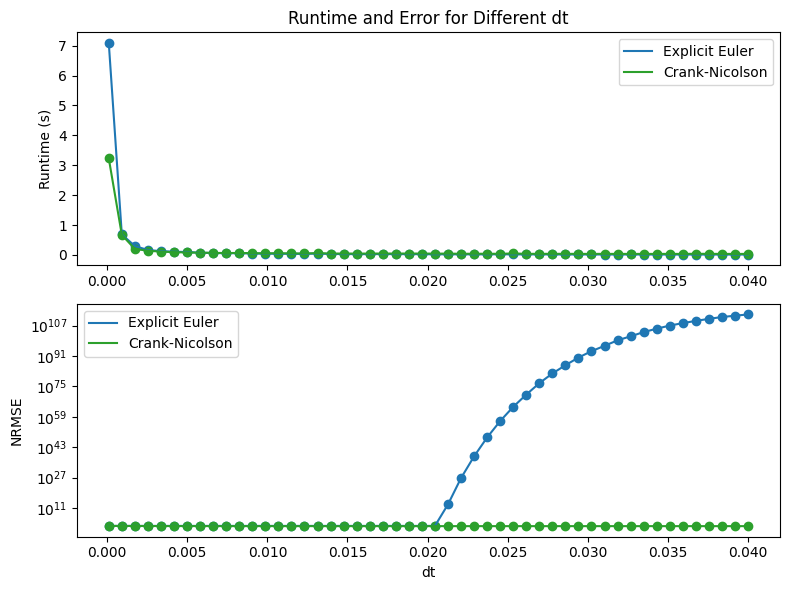

ValueError: x and y must have same first dimension, but have shapes (1,) and (50,)

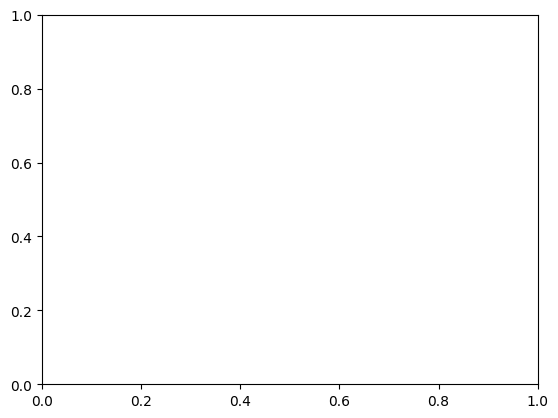

In [221]:
#run the simulations for different values of dt

kappa = 0.01

tmax = 10

dts = np.linspace(0.04, 0.0001, 50)

runtimes_EE = np.zeros(len(dts))
runtimes_CN = np.zeros(len(dts))
NRSMSEs_EE = np.zeros(len(dts))
NRSMSEs_CN = np.zeros(len(dts))


for i, dt in enumerate(dts):
  Nt_temporary = int(tmax / dt) + 1
  t_temporary = np.linspace(t_start, t_start + tmax, Nt_temporary)  # Create a vector of times
  c_EE, t_EE = EE_2(x, t_temporary, kappa) # explicit Euler
  c_CN, t_CN = CN_2(x, t_temporary, kappa) # Crank-Nicolson

  exact_sol = (1/(4*np.pi*kappa*tmax))**0.5 * np.exp(-exact_x**2/(4*kappa*tmax))

  #Calculate NRMSE
  NRMSE_EE = (np.sqrt(np.mean((c_EE[:,-1] - exact_sol)**2))/np.mean(exact_sol))*100
  NRMSE_CN = (np.sqrt(np.mean((c_CN[:,-1] - exact_sol)**2))/np.mean(exact_sol))*100

  #update dataframes
  runtimes_EE[i] = t_EE
  runtimes_CN[i] = t_CN
  NRSMSEs_EE[i] = NRMSE_EE
  NRSMSEs_CN[i] = NRMSE_CN
#print(f'Processing dt = {dt}...')

print('Done')
#now plot the results

fig, ax = plt.subplots(2, 1, figsize=(8,6))

ax[0].set_title('Runtime and Error for Different dt')
ax[0].plot(dts, runtimes_EE, color='tab:blue', label='Explicit Euler')
ax[0].plot(dts, runtimes_CN, color='tab:green', label='Crank-Nicolson')
ax[0].scatter(dts, runtimes_EE, color='tab:blue')
ax[0].scatter(dts, runtimes_CN, color='tab:green')


ax[1].plot(dts, NRSMSEs_EE, color='tab:blue', label='Explicit Euler')
ax[1].plot(dts, NRSMSEs_CN, color='tab:green', label='Crank-Nicolson')
ax[1].scatter(dts, NRSMSEs_EE, color='tab:blue')
ax[1].scatter(dts, NRSMSEs_CN, color='tab:green')
ax[1].set_yscale('log')
#ax[1].set_xscale('log')


ax[1].set_xlabel('dt')
ax[1].set_ylabel('NRMSE')
ax[0].set_ylabel('Runtime (s)')

ax[0].legend()
ax[1].legend()


plt.tight_layout()
plt.show()

max_error_EE = np.argmax(NRSMSEs_EE)
max_error_EE_t = dts[max_error_EE]

plt.plot(NRMSE_CN, runtimes_CN, color='tab:green')
plt.scatter(NRMSE_CN, runtimes_CN, color='tab:green')
plt.plot(NRMSE_EE, runtimes_EE, color='tab:blue')
plt.scatter(NRMSE_EE, runtimes_EE, color='tab:blue')

plt.title('NRMSE vs Runtime')
plt.xlabel('NRMSE')
plt.ylabel('Runtime (s)')
plt.show()

In [ ]:
#run the simulations for different values of dt

kappa = 0.01
tmax = 10

dts = np.linspace(0.00001, 0.1, 100)

runtimes_EE = np.zeros(len(dts))
runtimes_CN = np.zeros(len(dts))
NRSMSEs_EE = np.zeros(len(dts))
NRSMSEs_CN = np.zeros(len(dts))

exact_sol = (1/(4*np.pi*kappa*tmax))**0.5 * np.exp(-exact_x**2/(4*kappa*tmax))


for i, dt in enumerate(dts):
  Nt_temporary = int(tmax / dt) + 1
  t_temporary = np.linspace(t_start, t_start + tmax, Nt_temporary)  # Create a vector of times
  c_EE, t_EE = EE_2(x, t_temporary, kappa) # explicit Euler
  c_CN, t_CN = CN_2(x, t_temporary, kappa) # Crank-Nicolson

  #Calculate NRMSE
  NRMSE_EE = (np.sqrt(np.mean((c_EE[:,-1] - exact_sol)**2))/np.mean(exact_sol))*100
  NRMSE_CN = (np.sqrt(np.mean((c_CN[:,-1] - exact_sol)**2))/np.mean(exact_sol))*100

  #update dataframes
  runtimes_EE[i] = t_EE
  runtimes_CN[i] = t_CN
  NRSMSEs_EE[i] = NRMSE_EE
  NRSMSEs_CN[i] = NRMSE_CN
#print(f'Processing dt = {dt}...')

print('Done')

#now plot the results

fig, ax = plt.subplots(2, 1, figsize=(8,6))

ax[0].set_title('Runtime and Error for Different dt')
ax[0].plot(dts, runtimes_EE, color='tab:blue', label='Explicit Euler')
ax[0].plot(dts, runtimes_CN, color='tab:green', label='Crank-Nicolson')


ax[1].plot(dts, NRSMSEs_EE, color='tab:blue', label='Explicit Euler')
ax[1].plot(dts, NRSMSEs_CN, color='tab:green', label='Crank-Nicolson')
#ax[1].set_yscale('log')
#ax[1].set_xscale('log')


ax[1].set_xlabel('dt')
ax[1].set_ylabel('NRMSE')
ax[0].set_ylabel('Runtime (s)')

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

max_error_EE = np.argmax(NRSMSEs_EE)
max_error_EE_t = dts[max_error_EE]

print(f'Maximum error for Explicit Euler occurs at dt = {round(max_error_EE_t, 3)}')

Zooming out, there is a massive increase in the magnitude of error in the Explicit Euler method when x = 0.047. The numerical solver breaks down at this value of dt. We can explore this by running the simulation again around these values of dt:

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10,10))

for i, dt in enumerate([0.01, max_error_EE_t, 0.6]):
  Nt_temporary = int(tmax / dt) + 1
  t_temporary = np.linspace(t_start, t_start + tmax, Nt_temporary) # Create a vector of times
  c_EE, t_EE = EE_2(x, t_temporary, kappa) # explicit Euler
  c_CN, t_CN = CN_2(x, t_temporary, kappa) # Crank-Nicolson
  ax[i,0].pcolormesh(x, t_temporary, c_EE.T, shading='auto')
  ax[i,1].pcolormesh(x, t_temporary, c_CN.T, shading='auto')
  ax[i,0].set_ylabel('t')

ax[2,1].set_xlabel('x')
ax[2,0].set_xlabel('x')
ax[0,1].set_title('Explicit Euler')
ax[0,1].set_title('Crank-Nicolson')
plt.tight_layout()
plt.show()



Indeed, as anticipated, the Explicit Euler scheme has broken down at such a large dt. This is not much larger than the dt used in the simulations written for us above (~0.01), which demonstrates the narrow range of parameter values for which the Explicit Euler method remains stable. Above this value, the simulation has broken down and does not provide realistic results even though the NRMSE decreases past dt = 0.05. In contrast, the Crank-Nicolson scheme remains stable even at this larger value of dt (although the accuracy decreases).

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

look this up!!

In [ ]:
import numpy as np
import scipy.sparse as sp

def construct_M_neumann(x):
    """
    Construct second derivative matrix with Neumann (zero gradient) BCs.

    For Neumann BCs (dc/dx = 0 at boundaries), we use ghost points:
    - At left boundary: c[-1] = c[1] (ghost point)
      So: d2c/dx2|_0 = (c[1] - 2*c[0] + c[-1])/dx^2 = 2*(c[1] - c[0])/dx^2
    - At right boundary: c[N] = c[N-2] (ghost point)
      So: d2c/dx2|_N-1 = 2*(c[N-2] - c[N-1])/dx^2
    """
    Nx = len(x)
    dx = x[1] - x[0]

    # Start with standard second derivative stencil [1, -2, 1]/dx^2
    diagonals = [np.ones(Nx), -2*np.ones(Nx), np.ones(Nx)]
    offsets = [-1, 0, 1]
    M = sp.diags(diagonals, offsets, shape=(Nx, Nx), format='lil')

    # Modify first row for left Neumann BC
    M[0, :] = 0
    M[0, 0] = -2
    M[0, 1] = 2

    # Modify last row for right Neumann BC
    M[-1, :] = 0
    M[-1, -1] = -2
    M[-1, -2] = 2

    # Scale by 1/dx^2
    M = M / dx**2

    return M.tocsr()


def construct_M_dirichlet(x):
    """
    Construct second derivative matrix with Dirichlet (fixed value) BCs.

    For Dirichlet BCs (c = constant at boundaries), we set the boundary
    rows to zero so that dc/dt = 0 at boundaries (no evolution).
    The boundary values must be enforced separately in the time loop.
    """
    Nx = len(x)
    dx = x[1] - x[0]

    # Start with standard second derivative stencil [1, -2, 1]/dx^2
    diagonals = [np.ones(Nx), -2*np.ones(Nx), np.ones(Nx)]
    offsets = [-1, 0, 1]
    M = sp.diags(diagonals, offsets, shape=(Nx, Nx), format='lil')
    M = M / dx**2

    # Zero out boundary rows (no time evolution at boundaries)
    M[0, :] = 0
    M[-1, :] = 0

    return M.tocsr()


# Example usage
if __name__ == "__main__":
    x = np.linspace(-10, 10, 21)

    print("Neumann BC matrix (first 3 and last 3 rows):")
    M_neumann = construct_M_neumann(x)
    print(M_neumann.toarray()[:3, :5])
    print("...")
    print(M_neumann.toarray()[-3:, -5:])

    print("\nDirichlet BC matrix (first 3 and last 3 rows):")
    M_dirichlet = construct_M_dirichlet(x)
    print(M_dirichlet.toarray()[:3, :5])
    print("...")
    print(M_dirichlet.toarray()[-3:, -5:])

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)